In [8]:
import numpy as np
import pandas as pd
from numpy import ndarray
from scipy.stats import gaussian_kde
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
# types for type hinting
from typing import Tuple


In [3]:
# Read the CSV file
file_path = '../cme_and_electron/cme_josias_10MeV.csv'
df = pd.read_csv(file_path)

In [4]:
def split_data(df):
    """
    Splits the data into training, validation, and test sets according to the specified rules.
    
    :param:
    - df: DataFrame containing the data. Assumes 'log_peak_intensity' is the target column.
    
    :return:
    - train_x, train_y, val_x, val_y, test_x, test_y: Numpy arrays containing the split data
    """
    # Sort the DataFrame by 'log_peak_intensity' in descending order
    df_sorted = df.sort_values(by='log_peak_intensity', ascending=False).reset_index(drop=True)
    
    # Initialize empty lists to store indices for training, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Group every 3 rows for test set selection
    for i in range(0, len(df_sorted), 3):
        group = list(range(i, min(i + 3, len(df_sorted))))
        test_idx = np.random.choice(group, 1)[0]
        train_indices.extend([idx for idx in group if idx != test_idx])
        test_indices.append(test_idx)
    
    # Group every 4 rows for validation set selection from the training set
    for i in range(0, len(train_indices), 4):
        group = train_indices[i: i + 4]
        if len(group) == 0:
            continue
        val_idx = np.random.choice(group, 1)[0]
        val_indices.append(val_idx)
        train_indices = [idx for idx in train_indices if idx != val_idx]
    
    # Extract the feature and target sets based on selected indices
    features = df_sorted.drop(columns=['log_peak_intensity']).to_numpy()
    target = df_sorted['log_peak_intensity'].to_numpy()
    
    train_x = features[train_indices]
    train_y = target[train_indices]
    val_x = features[val_indices]
    val_y = target[val_indices]
    test_x = features[test_indices]
    test_y = target[test_indices]
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Test the function
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df)

# Show the shape of the resulting arrays to ensure correctness
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (test_x.shape, test_y.shape)


(((1264, 24), (1264,)), ((316, 24), (316,)), ((790, 24), (790,)))

In [5]:
def plot_sorted_distributions(y_train, y_val, y_test, title='Sorted Distributions'):
    """
    Plots the sorted target variable distributions for the training, validation, and test sets.
    
    :param:
    - y_train: Numpy array containing the training set target variable
    - y_val: Numpy array containing the validation set target variable
    - y_test: Numpy array containing the test set target variable
    - title: Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Sort and plot the target variable for each set
    plt.plot(np.sort(y_train), label='Train', marker='o')
    plt.plot(np.sort(y_val), label='Validation', marker='x')
    plt.plot(np.sort(y_test), label='Test', marker='s')
    
    plt.xlabel('Index')
    plt.ylabel('log_peak_intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

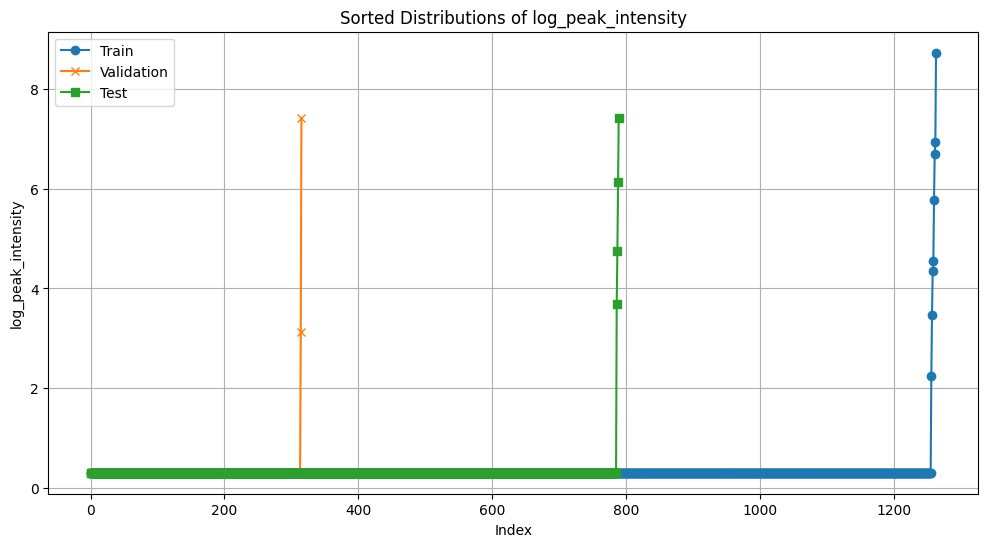

In [6]:
plot_sorted_distributions(train_y, val_y, test_y, title='Sorted Distributions of log_peak_intensity')

In [9]:
def shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Shuffle the data within each of the training, validation, and test sets.
    
    :param:
    - train_x, train_y: Numpy arrays containing the training features and labels
    - val_x, val_y: Numpy arrays containing the validation features and labels
    - test_x, test_y: Numpy arrays containing the test features and labels
    
    :return:
    - Shuffled versions of train_x, train_y, val_x, val_y, test_x, test_y
    """
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Shuffle the datasets
shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, shuffled_test_x, shuffled_test_y = shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y)
